#Assignment 2:
    test the difference between a Binomial/Poisson distribution and a Gaussian distribution as you change the parameters of the Binomial/Poisson. Use: 
    
    1) KS
    
    2) KL or Chisq
    
    3) AD
    
    6 test total (8 if you are ambitious and want to try Pearson's chisq)
    
    i want you to use the scipy.stats package for this. it will provide tests. For KS and AD you will simply need to generate the distribution the normal will be tested agains: the KS and AD functions in scipy have functionality to test against standard distributions (normal, chisq etc) without you having to code up anything about the distribution itself. KL and chisq do not. I am showing you how to do the AD, KS and KL for binomial, you can replicate it for the poisson or do the Chisq instead of KL.
    
    even if you just replicate it... PLEASE UNDESRTAND IT! or you will have learned nothing and wasted both of our times

my usual imports and setups

In [2]:
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

import os

#this makes my plots pretty! but it is totally not mandatory to do it
import json
s = json.load( open("fbb_matplotlibrc.json") )
pl.rcParams.update(s)

#plus importing scipy.stats
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


here are the manual pages fo the tests
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html#scipy.stats.entropy

i need to figure out what each test function returns. let me run them once to see (and read the manual atthe same time!)

i am testing for normal against normal and for a binomial w small n*p against normal. that will give me very different outcomes.


#####My Notes
stats.normaltest is based on deviations of skew and kurtosis from those of the normal distribution.

Anderson-Darling is based on a integral of the weighted squared differences between the cdf.

Kolmogorov-Smirnov is based on the maximum absolute difference between the cdf.

chisquare for binned data would be based on the weighted sum of squared bin probabilities.

Use scipy.stats.entropy to estimate the Kullback–Leibler (KL) divergence between two distributions. More specifically, I would like to use the KL as a metric to decide how consistent two distributions are.


In [3]:
#generate the distribution
dist_n = np.random.randn(1000)

#test ad and ks. those are easy
#ks returns ks statistic and p-value
#Anderson returns A2, critical value and significance level
print "normal on normal", scipy.stats.kstest(dist_n,'norm')
print "normal on normal", scipy.stats.anderson(dist_n, dist='norm')
print "" 
 
dist_b = np.random.binomial(1, 0.5, 1000)

print "Binomial on normal", scipy.stats.kstest(dist_b,'norm')
print "Binomial on normal", scipy.stats.anderson(dist_b, dist='norm')

#Anderson-Darling test
#If A2 is larger than these critical values then for the corresponding significance level, 
#the null hypothesis that the data come from the chosen distribution can be rejected.

threshold = scipy.stats.anderson(dist_n, dist='norm')[1][scipy.stats.anderson(dist_n, dist='norm')[2]==[1.0]]
print threshold

##what is this threshold I am saving??
#save the critical value when significance level = 1%

normal on normal (0.022585442164418046, 0.68746081058959674)
normal on normal (0.21101518219984428, array([ 0.574,  0.653,  0.784,  0.914,  1.088]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

Binomial on normal (0.5, 0.0)
Binomial on normal (179.66430119760707, array([ 0.574,  0.653,  0.784,  0.914,  1.088]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
[ 1.088]


the statistics value will be **larger** if the distributions are **not** likely to be related. 
think about this in terms of rejection of the NULL hypothesis. 

#try writing down the null for each test and see if scipy manual agrees with you         (the manual spells out the Null)

#####K-S Test Null Hypothesis: 
The two samples are drawn from the same distribution or that the sample is drawn from the reference distribution (in the one-sample case)
####Anderson-Darling Test Null Hypothesis: 
The sample of data comes from a specific distribution.
####KL Test Null Hypothesis:
The two distributions are consistent. (The smaller the KL divergence is, the more "closer" the two distributions are)

----------------------------

the KL divergence is a little trickier: i have to pass it the values of the distribution at some x's: that means i have to pass it a **NORMALIZED HOSTOGRAM OF MY DISTRIBUTION**, i.e. derive a PDF from the data. we have done it before!

i have to pass it a function for my comparison distribution evaluated at the x-values where my empirical distribution is evaluated.  not just the name of a distribution

see this too: http://stackoverflow.com/questions/26743201/interpreting-scipy-stats-entropy-values

In [4]:
distpdf_n, mybins_n, = np.histogram(dist_n, density=True)
distpdf_b, mybins_b, = np.histogram(dist_b, density=True)
#notice the extra comma on the left side of the '=' sign: that tells numpy take the first two values returned, 
#and throw away the rest


then i have to pass it the functional form of a normal PDF, which is returned by the function scipy.stats.norm for example (a google search would have told you!) 
evaluated at the bin centers of the histogram from before

In [5]:
#get the bin centers
bincenters_n = mybins_n[:-1] + 0.5*(mybins_n[1] - mybins_n[0])
bincenters_b = mybins_b[:-1] + 0.5*(mybins_b[1] - mybins_b[0])
print "normal on normal", scipy.stats.entropy(distpdf_n, scipy.stats.norm.pdf(bincenters_n))  
print "Binomial on normal", scipy.stats.entropy(distpdf_b, scipy.stats.norm.pdf(bincenters_b)) 

#you can interpret this as a distance: it increases as the distributions diverge

normal on normal 0.00170021377934
Binomial on normal 1.67415166333


####So it looks like a high value is rejecting the NULL that the our tested binomial distribution is far from the normal distribution.

#BINOMIAL

In [6]:
#To store the data i am generating an empty array of the size of the values of n i want to test. 
#I do that with np.zeros which takes the length of the array as argument, 
#and the data type as optional argument, but default is float, which is fine by me, 
#so i do not need any argument other then the lenghth 
narray = range(1,50,1)
ks_b = np.zeros(len(narray))
ad_b = np.zeros(len(narray))
kl_b = np.zeros(len(narray))
chi2_b = np.zeros(len(narray))

print 
def mynorm (x, mu, var):
    return scipy.stats.norm.cdf(x, loc=mu, scale=var)

#then i put the tests in a for loop so that i can generate a distribution for given parameters once, 
#and run all tests against it
#now the valus that i want to plot depends on how i intend to describe the plot, and viceversa. 

p=0.5
for i,n in enumerate(narray):
    p=0.1 #parameter for the binomial, my arbitrary choice
    #generate the distribution
    dist = np.random.binomial(n, p, 1000)
    #run the tests. 

    #Binomial: mean:n*p, variance:n*p*(1-p)
    ks_b[i] = scipy.stats.kstest(dist, mynorm, args=(n*p, n*p*(1.0-p)))[0]
    ad_b[i] = scipy.stats.anderson(dist, dist='norm')[0]
    
    
    # for KL and Pearson's chisq I have to simulate the normal distribution as well
    mybins=np.linspace(min(dist),max(dist), 10) 
    bincenters = mybins[:-1]+0.5*(mybins[1]-mybins[0])

    #when i was coding this up something was wrong. i put some plots in to figure out what... just so you know.
    #if i%10 == 0: 
    #    print n
    #    pl.figure()
    #    pl.hist(dist, bins=mybins)
    #    pl.plot(bincenters, 1000*scipy.stats.norm.pdf(bincenters, loc=n*p, scale=n*p*(1-p)))
    kl_b [i] =  scipy.stats.entropy(np.histogram(dist, bins=mybins)[0], scipy.stats.norm.pdf(bincenters, loc=n*p, scale=n*p*(1.0-p)))
    

#this is just one way to plot it. get creative and find the best way to show your result!
then give me a cell in which you write a caption for the figures you plot. think about how the captions are written in the paper  you have to read for this week assignment: a caption must describe the plot sufficiently well that i do not need to read the paper to understand it. though it will generally lack details of the how and why you see what you see. those are in the paper

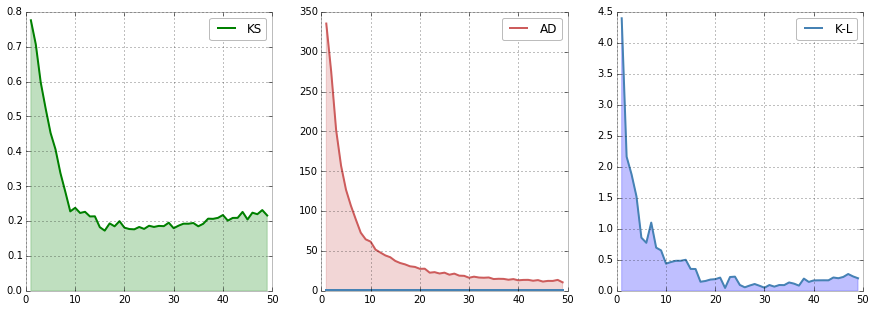

In [7]:
fig = pl.figure(figsize = (15,5))
fig.add_subplot(131)
pl.plot(narray, ks_b, label='KS', color='Green')
plt.fill_between(narray, ks_b, color='Green', alpha=.25)
pl.legend()

fig.add_subplot(132)
pl.plot(narray, ad_b,  label='AD',color='Indianred')
pl.plot([narray[0], narray[-1]],[threshold, threshold])
pl.plot()
pl.plot()
plt.fill_between(narray, ad_b, color='Indianred', alpha=.25)
pl.legend()

#print narray
#print narray[0]
#print narray[-1]

fig.add_subplot(133)
pl.plot(narray, kl_b, label='K-L ')
plt.fill_between(narray, kl_b, color='blue', alpha=.25)

pl.legend()

###Compare a Binomial distribution sample with Normal distribution by KS, Anderson and KL Test

#POISSON

In [8]:
#to store the data i am generating an empty array of the size of the values of n i want to test. i do that with np.zeros which takes the length of the array as argument, and the data type as optional argument, but default is float, which is fine by me, so i do not need any argument other then the lenght 
narray = range(1,50,1)
ks_p = np.zeros(len(narray))
ad_p = np.zeros(len(narray))
kl_p = np.zeros(len(narray))
chi2_p = np.zeros(len(narray))

def mynorm (x, mu, var):
    return scipy.stats.norm.cdf(x, loc=mu, scale=var)
#then i put the tests in a for loop so that i can generate a distribution for given parameters once, 
#and run all tests against it
#now the valus that i want to plot depends on how i intend to describe the plot, and viceversa. 

#here is one way to plot it, knowing the values i get for the tests when 
#i throw in a poisson distribution with low l and compare it with a gaussian and 
#assuming that that is a vary bad match

for i,n in enumerate(narray):
    #p=0.1 
    #generate the distribution
    dist = np.random.poisson(n, 1000)
    #run the tests. 
    #Possion: mean:n, variance:n
    ks_p[i] = scipy.stats.kstest(dist, mynorm, args=(n, n))[0]
    #The ks result still looks wierd?
    ad_p[i] = scipy.stats.anderson(dist, dist='norm')[0]
        
    # for KL and Pearson's chisq I have to simulate the normal distribution as well
    mybins = np.linspace(min(dist),max(dist), 10) 
    bincenters = mybins[:-1]+0.5*(mybins[1]-mybins[0])
 
    kl_p [i] =  scipy.stats.entropy(np.histogram(dist, bins=mybins)[0], scipy.stats.norm.pdf(bincenters, loc=n*p, scale=n*p*(1.0-p)))
    

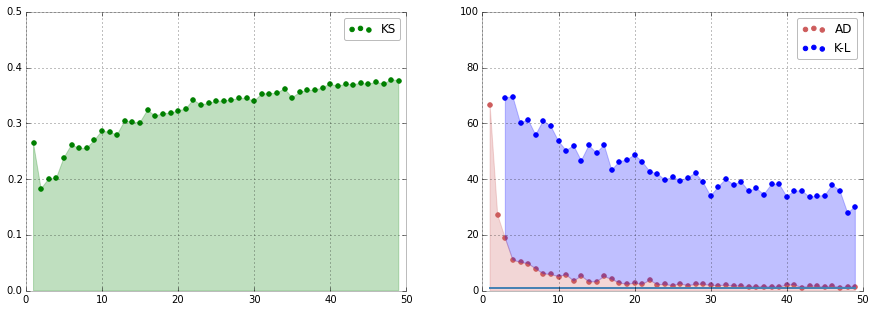

In [9]:
fig = pl.figure(figsize = (15,5))
fig.add_subplot(121)
pl.scatter(narray, ks_p, label='KS',color='green')
pl.fill_between(narray, ks_p, color='green', alpha=.25)
pl.xlim(0,50)
pl.ylim(0,0.5)
pl.legend()

fig.add_subplot(122)
pl.scatter(narray, ad_p,  label='AD',color='indianred')
pl.plot([narray[0], narray[-1]],[threshold, threshold])
pl.plot()
pl.plot()
pl.fill_between(narray, kl_p, ad_p, color='blue', alpha=.25)
pl.fill_between(narray, ad_p, 0, color='indianred', alpha=.25)
pl.legend()

#fig.add_subplot(133)
pl.scatter(narray, kl_p, label='K-L', color='blue')
pl.xlim(0,50)
pl.ylim(0,100)
pl.legend()

###Compare a Poisson distribution sample with Normal distribution by KS, Anderson and KL Test

##TOTALLY OPTIONAL fun with KL: the KL divergence is a measure of how much approximation you have to do to represent one distribution with the other. you can see what it looks point by point, before you integrate and get a single distance number

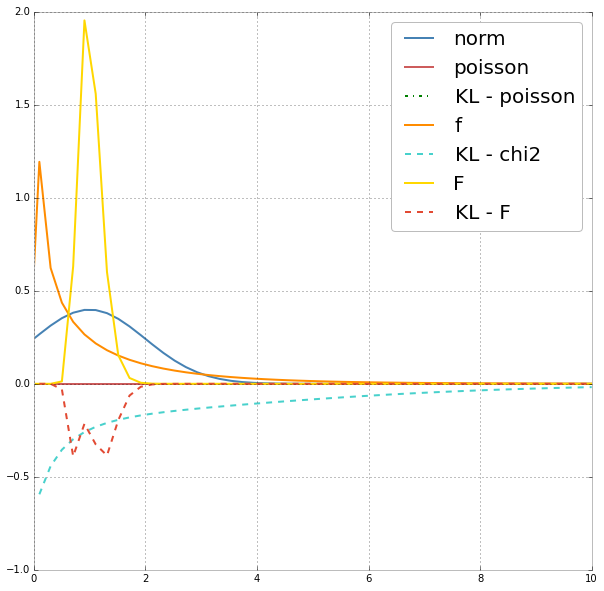

In [84]:
pl.figure(figsize=(10,10))

p = lambda x, mu : scipy.stats.distributions.poisson.pmf(x,mu)
q = lambda x, mu : scipy.stats.distributions.norm.pdf(x-mu)
c = lambda x, mu : scipy.stats.distributions.chi2.pdf(x, df=mu)
f = lambda x, mu : scipy.stats.distributions.f.pdf(x,100,100)

Dkl = lambda x ,mu, p :  p(x, mu)* np.log10(q(x, mu)) + p(x, mu) *np.log10(p(x, mu))

def model(x) : 
    return 1./(s*np.sqrt(2*np.pi))*exp(-((x-m)/2./2./s)**2)

x=np.linspace(-10,10,100)
pl.plot(x, q(x,1), label='norm')
pl.plot(x, p(x,1), label='poisson')
pl.plot(x, Dkl(x, 1, p), '-.', label = 'KL - poisson')

#print np.nansum(Dkl(np.linspace(0,30,1000), 1, p))

pl.plot(x, c(x,1), label='f')
pl.plot(x,Dkl(x, 1, c), '--', label = 'KL - chi2')

#print np.nansum(Dkl(np.linspace(0,30,1000), 1, c))

pl.plot(x, f(x,1), label='F')
pl.plot(x,Dkl(x, 1, f), '--', label = 'KL - F')

#print np.nansum(Dkl(np.linspace(0,30,1000), 1, f))
bins = np.arange(0, 99, 10)

pl.xlim(0,10)
pl.legend( fontsize = 20)

##WRITE A CAPTION HERE IN THIS CELL..
###Kullback–Leibler (KL) Divergence Estimation for Different Types of Probablity Distributions